In [1]:
import os
import time

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import h5py
import numpy as np
import pandas as pd
import tensorflow as tf

import baskerville
from baskerville import bed
from baskerville import dataset
from baskerville import seqnn
from baskerville import trainer
from baskerville import gene as bgene
from baskerville import dna_io

import json

import pyranges as pr

import pysam

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from borzoi_helpers import *


2023-08-07 11:23:12.401555: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 11:23:14.244718: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-07 11:23:14.244845: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-07 11:23:14.244857: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [ ]:
#Model configuration

params_file = 'params_pred.json'
targets_file = 'targets_gtex.txt'

seq_len = 524288
n_folds = 4

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Initialize model ensemble

models = []
for fold_ix in range(n_folds) :
    
    model_file = "saved_models/f" + str(fold_ix) + "c0/train/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0) #, by_name=False
    seqnn_model.build_slice(target_index)
    seqnn_model.build_ensemble(True, '0')
    
    models.append(seqnn_model)


In [4]:
#Load splice site annotation

splice_df = pd.read_csv('gencode41_basic_protein_splice.csv.gz', sep='\t', compression='gzip')

print("len(splice_df) = " + str(len(splice_df)))


len(splice_df) = 404837


In [5]:
#Initialize fasta sequence extractor

fasta_file = 'hg38.fa'

#Run code below if you need to download hg38
#import pyfaidx

#!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
#pyfaidx.Faidx(fasta_file)

fasta_open = pysam.Fastafile(fasta_file)


2023-08-07 11:26:08.216160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-08-07 11:26:08.516848: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


-- Counts --
 - max_y_wt = 394.8012
 - max_y_mut = 434.8128
 -- (max_y = 434.8128)


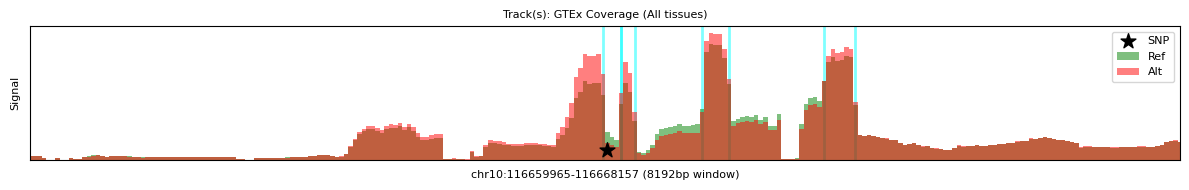

 - max_y_wt = 549.9594
 - max_y_mut = 606.7306
 -- (max_y = 606.7306)


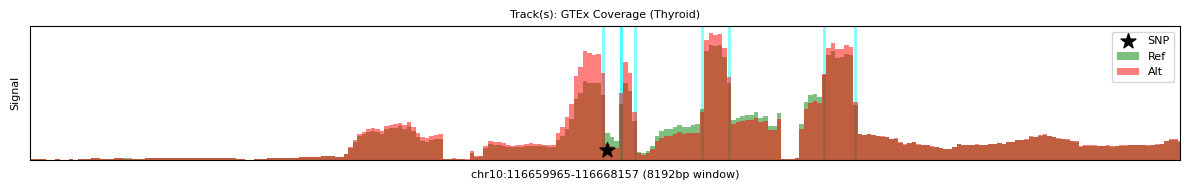

 - max_y_wt = 325.4685
 - max_y_mut = 349.4247
 -- (max_y = 349.4247)


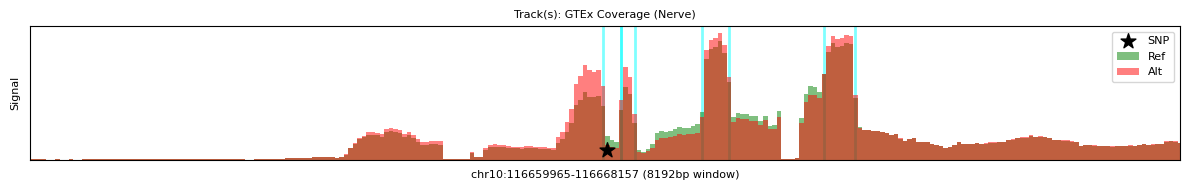

In [6]:
#Predict for chr10_116664061_G_A

save_figs = False
save_suffix = '_chr10_116664061_G_A'

center_pos = 116664061

chrom = 'chr10'
poses = [116664061]
alts = ['A']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

#Induce mutation(s)
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

for pos, alt in zip(poses, alts) :
    alt_ix = -1
    if alt == 'A' :
        alt_ix = 0
    elif alt == 'C' :
        alt_ix = 1
    elif alt == 'G' :
        alt_ix = 2
    elif alt == 'T' :
        alt_ix = 3

    sequence_one_hot_mut[pos-start-1] = 0.
    sequence_one_hot_mut[pos-start-1, alt_ix] = 1.

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)

#Visualize quantized tracks over SNP

plot_window = 4096 * 2
bin_size = 32
pad = 16

rescale_tracks = True
normalize_counts = False

anno_df = splice_df

#Tracks
track_indices = [
    np.arange(0, 89).tolist(),
    [81, 82, 83],
    [50, 51],
]

track_names = [
    'GTEx Coverage (All tissues)',
    'GTEx Coverage (Thyroid)',
    'GTEx Coverage (Nerve)',
]

track_scales = [
    0.01,
    0.01,
    0.01,
]

track_transforms = [
    3./4.,
    3./4.,
    3./4.,
]

soft_clips = [
    384.,
    384.,
    384.,
]

print("-- Counts --")
plot_coverage_track_pair_bins(y_wt, y_mut, chrom, start, center_pos, poses, track_indices, track_names, track_scales, track_transforms, soft_clips, plot_window=plot_window, normalize_window=8*plot_window, bin_size=bin_size, pad=pad, rescale_tracks=rescale_tracks, normalize_counts=normalize_counts, save_figs=save_figs, save_suffix=save_suffix, anno_df=anno_df)


In [7]:
#Print splice site bin positions and other info

plot_start = center_pos - plot_window // 2
plot_end = center_pos + plot_window // 2

plot_start_bin = (plot_start - start) // bin_size - pad
plot_end_bin = (plot_end - start) // bin_size - pad

mut_bin = (poses[0] - start) // bin_size - pad

#Get splice site positions
splice_poses = splice_df.query("chrom == '" + chrom + "' and position_hg38 >= " + str(plot_start) + " and position_hg38 < " + str(plot_end))['position_hg38'].unique().tolist()

print("mut_bin = " + str(mut_bin))
print("")

#Print splice site positions
for splice_ix, splice_pos in enumerate(splice_poses) :
    
    splice_bin = int((splice_pos - start) // 32) - 16
    
    bin_end = splice_bin + 3
    bin_start = bin_end - 5
    
    print("splice_ix = " + str(splice_ix) + ": bin = " + str(splice_bin) + " (" + str(bin_start) + " - " + str(bin_end) + ")")


mut_bin = 8176

splice_ix = 0: bin = 8175 (8173 - 8178)
splice_ix = 1: bin = 8179 (8177 - 8182)
splice_ix = 2: bin = 8179 (8177 - 8182)
splice_ix = 3: bin = 8182 (8180 - 8185)
splice_ix = 4: bin = 8197 (8195 - 8200)
splice_ix = 5: bin = 8203 (8201 - 8206)
splice_ix = 6: bin = 8224 (8222 - 8227)
splice_ix = 7: bin = 8231 (8229 - 8234)


In [8]:
#Choose splice sites to use for attributions

exon_1_start_bin = 8173
exon_1_end_bin = 8176

exon_2_start_bin = 8176
exon_2_end_bin = 8179


In [ ]:
#Get contribution scores (gradient) for nerve GTEX tracks

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    exon_2_start_bin,
    exon_2_end_bin,
    exon_1_start_bin,
    exon_1_end_bin,
    target_index[[50, 51]].tolist(),
    0.01,
    3./4.,
    clip_soft=384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False,
    subtract_avg=True,
    fold_index=[0, 1, 2, 3],
)


--- WT ---


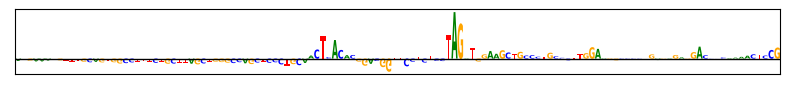

--- Mut ---


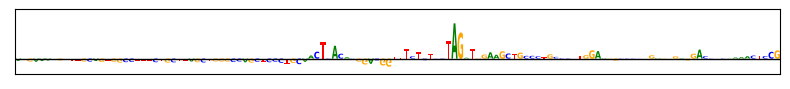

In [14]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_grad_wt[::-1, ::-1],
    pred_grad_mut[::-1, ::-1],
    plot_start=seq_len - (poses[0] - start) - 64 - 1,
    plot_end=seq_len - (poses[0] - start) + 64 - 1,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_grad_gtex_snp_4_folds_gtex_cov_nerve_undo_clip'
)


In [ ]:
#Get contribution scores (ISM) for nerve GTEX tracks

[pred_ism_wt, pred_ism_mut] = get_ism(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (poses[0] - start) - 64,
    (poses[0] - start) + 64,
    exon_2_start_bin,
    exon_2_end_bin,
    exon_1_start_bin,
    exon_1_end_bin,
    [50, 51],
    0.01,
    3./4.,
    384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False
)


--- WT ---


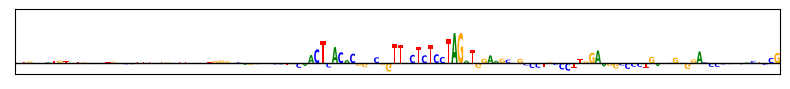

--- Mut ---


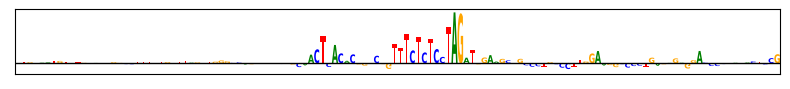

In [18]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt[::-1, ::-1],
    pred_ism_mut[::-1, ::-1],
    plot_start=seq_len - (poses[0] - start) - 64 - 1,
    plot_end=seq_len - (poses[0] - start) + 64 - 1,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_gtex_snp_4_folds_gtex_cov_nerve_undo_clip'
)


In [ ]:
#Get contribution scores (ISM shuffle) for nerve GTEX tracks

[pred_ism_wt, pred_ism_mut] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (poses[0] - start) - 64,
    (poses[0] - start) + 64,
    exon_2_start_bin,
    exon_2_end_bin,
    exon_1_start_bin,
    exon_1_end_bin,
    [50, 51],
    0.01,
    3./4.,
    384.,
    window_size=5,
    n_samples=24,
    use_mean=False,
    use_ratio=True,
    use_logodds=False
)


--- WT ---


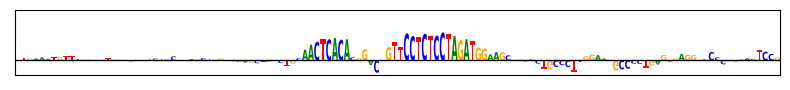

--- Mut ---


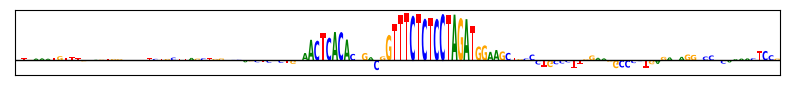

In [22]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt[::-1, ::-1],
    pred_ism_mut[::-1, ::-1],
    plot_start=seq_len - (poses[0] - start) - 64 - 1,
    plot_end=seq_len - (poses[0] - start) + 64 - 1,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_shuffle_gtex_snp_4_folds_gtex_cov_nerve_undo_clip'
)


In [9]:
#Choose new exons to use for attributions (isolate intronic polyadenylation determinant)

pas_pos = 116664310

exon_1_start_bin = 8170
exon_1_end_bin = 8176

exon_2_start_bin = 8197
exon_2_end_bin = 8203


In [ ]:
#Get contribution scores (gradient) for nerve GTEX tracks

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    exon_2_start_bin,
    exon_2_end_bin,
    exon_1_start_bin,
    exon_1_end_bin,
    target_index[[50, 51]].tolist(),
    0.01,
    3./4.,
    clip_soft=384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False,
    subtract_avg=True,
    fold_index=[0, 1, 2, 3],
)


--- WT ---


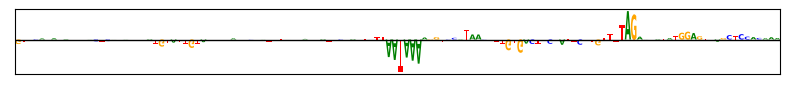

--- Mut ---


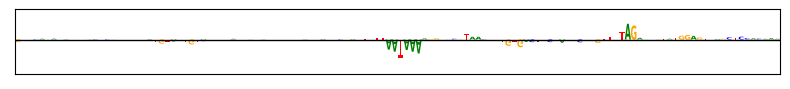

In [27]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_grad_wt[::-1, ::-1],
    pred_grad_mut[::-1, ::-1],
    plot_start=seq_len - (pas_pos - start) - 64 - 1,
    plot_end=seq_len - (pas_pos - start) + 64 - 1,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_grad_gtex_snp_4_folds_gtex_pas_cov_nerve_undo_clip'
)


In [ ]:
#Get contribution scores (ISM) for nerve GTEX tracks

[pred_ism_wt, pred_ism_mut] = get_ism(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (pas_pos - start) - 64,
    (pas_pos - start) + 64,
    exon_2_start_bin,
    exon_2_end_bin,
    exon_1_start_bin,
    exon_1_end_bin,
    [50, 51],
    0.01,
    3./4.,
    384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False
)


--- WT ---


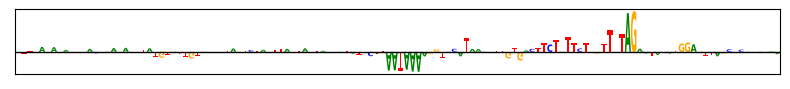

--- Mut ---


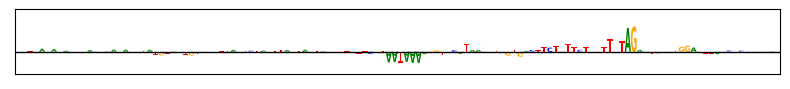

In [31]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt[::-1, ::-1],
    pred_ism_mut[::-1, ::-1],
    plot_start=seq_len - (pas_pos - start) - 64 - 1,
    plot_end=seq_len - (pas_pos - start) + 64 - 1,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_gtex_snp_4_folds_gtex_pas_cov_nerve_undo_clip'
)


In [ ]:
#Get contribution scores (ISM shuffle) for nerve GTEX tracks

[pred_ism_wt, pred_ism_mut] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (pas_pos - start) - 64,
    (pas_pos - start) + 64,
    exon_2_start_bin,
    exon_2_end_bin,
    exon_1_start_bin,
    exon_1_end_bin,
    [50, 51],
    0.01,
    3./4.,
    384.,
    window_size=5,
    n_samples=24,
    use_mean=False,
    use_ratio=True,
    use_logodds=False
)


--- WT ---


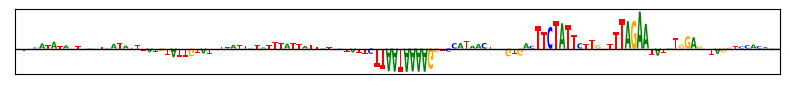

--- Mut ---


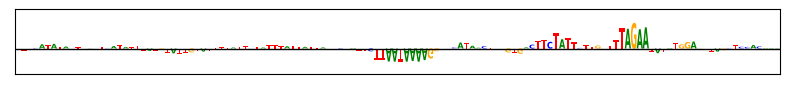

In [35]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt[::-1, ::-1],
    pred_ism_mut[::-1, ::-1],
    plot_start=seq_len - (pas_pos - start) - 64 - 1,
    plot_end=seq_len - (pas_pos - start) + 64 - 1,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_shuffle_gtex_snp_4_folds_gtex_pas_cov_nerve_undo_clip'
)


In [10]:
#Load samples with reference- and alternate alleles respectively

#These files are protected by dbGaP - email to request access

cov_files_wt = pd.read_csv("gtex_ref_chr10_116664061_G_A.txt", sep='\t', names=['file'])['file'].values.tolist()
cov_files_mut = pd.read_csv("gtex_alt_chr10_116664061_G_A.txt", sep='\t', names=['file'])['file'].values.tolist()


gtex_targets_wt.shape = (16352, 31)
gtex_targets_mut.shape = (16352, 31)
-- Counts --
 - max_y_wt = 2566.1792
 - max_y_mut = 2891.292
 -- (max_y = 2891.292)


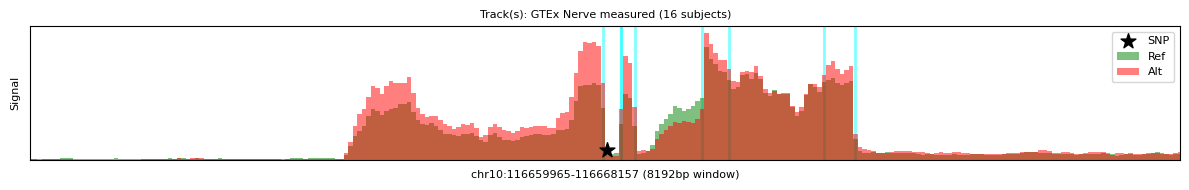

In [11]:
#Read measured coverage tracks for chr10_116664061_G_A

save_figs = False
save_suffix = '_chr10_116664061_G_A_meas_16_subjects'

center_pos = 116664061

chrom = 'chr10'
poses = [116664061]
alts = ['A']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

blacklist_bed = "/home/drk/common/data/genomes/hg38/blacklist/blacklist_hg38_all.bed"

read_coverage_func_wt, close_coverage_func_wt = get_coverage_reader(cov_files_wt, 16384, 16, blacklist_bed)
read_coverage_func_mut, close_coverage_func_mut = get_coverage_reader(cov_files_mut, 16384, 16, blacklist_bed)

gtex_targets_wt = read_coverage_func_wt(chrom, start, end, clip_soft=384., clip=768., scale=0.01)
gtex_targets_mut = read_coverage_func_mut(chrom, start, end, clip_soft=384., clip=768., scale=0.01)

close_coverage_func_wt()
close_coverage_func_mut()

print("gtex_targets_wt.shape = " + str(gtex_targets_wt.shape))
print("gtex_targets_mut.shape = " + str(gtex_targets_mut.shape))

plot_window = 4096 * 2
bin_size = 32
pad = 16

rescale_tracks = True
normalize_counts = True

#Tracks
track_indices = [
    np.arange(16),
]

track_names = [
    'GTEx Nerve measured (16 subjects)',
]

track_scales = [
    0.01,
]

track_transforms = [
    3./4.,
]

soft_clips = [
    384.,
]

print("-- Counts --")
plot_coverage_track_pair_bins(gtex_targets_wt[None, None, ...], gtex_targets_mut[None, None, ...], chrom, start, center_pos, poses, track_indices, track_names, track_scales, track_transforms, soft_clips, plot_window=plot_window, normalize_window=8*plot_window, bin_size=bin_size, pad=pad, rescale_tracks=rescale_tracks, normalize_counts=normalize_counts, save_figs=save_figs, save_suffix=save_suffix, anno_df=anno_df)
